In [1]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from geopy.distance import geodesic

In [2]:
path = "/mnt/home/jieyaqi/code/FMST/Shell_for_FMM/file"
sacfile = "/mnt/ufs18/nodr/home/jieyaqi/east_africa/all_debias/sacfile.txt"
perlist = [5, 7, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45]
stationfile = "/mnt/home/jieyaqi/Documents/station.txt"
ccfpath = "/mnt/ufs18/nodr/home/jieyaqi/east_africa/all_debias"

In [3]:
def get_ccf_dic():
    # get ccf dictionary
    with open(sacfile, 'r') as f:
        ccfs = f.readlines()
    ccfdic = {ccf.strip().split(' ')[3]:ccf.split(' ')[2] for ccf in ccfs}
    return ccfdic

In [4]:
def remove_null(a):
    while '' in a:
        a.remove('')
    return a

In [5]:
def get_ccf_list(per, ccfdic):
    # check ccf list
    I2 = []
    I3 = []
    ccffile = f'{path}/out_phase.{per}.dat'
    with open(ccffile,'r') as f:
        lines = f.readlines()
    for line in lines:
        ccf = remove_null(line.split(' '))[8]
        if ccfdic[ccf] == 'I2':
            I2.append(ccf)
        elif 'I3' in ccfdic[ccf]:
            I3.append(ccf)
    return I2, I3

In [6]:
def cal_distance(sac):
    '''
    calculate distance between station pairs
    '''
    stationList = np.loadtxt(stationfile,unpack = True ,delimiter='|',dtype=str)
    sourcenet = sac.split('.')[0].split('_')[1]
    sourcesta = sac.split('.')[1]
    receivernet = sac.split('.')[2]
    receiversta = sac.split('.')[3]
    sourcemark = [stationList[1][stationList[0]==sourcenet],
                  stationList[3][stationList[0]==sourcenet],
                  stationList[2][stationList[0]==sourcenet]]
    receivermark = [stationList[1][stationList[0]==receivernet],
                    stationList[3][stationList[0]==receivernet],
                    stationList[2][stationList[0]==receivernet]]
    distance = geodesic((sourcemark[1][sourcemark[0]==sourcesta][0],sourcemark[2][sourcemark[0]==sourcesta][0]),
                        (receivermark[1][receivermark[0]==receiversta][0],receivermark[2][receivermark[0]==receiversta][0]))
    return distance.km

In [7]:
def get_displace(per, ccfs, path, keysta, amplifier):
    disstack = []
    for ccf in ccfs:
        if keysta not in ccf:
            continue
        sacpath = f'{path}/{ccf}'
        try:
            tra = obspy.read(sacpath,format='sac')
        except IndexError:
            continue
        tra.filter('bandpass',freqmin=1/20,freqmax=1/5)
        tra[0].normalize()
        displacement = tra[0].data
        distance = cal_distance(ccf)
        displacement_d = displacement*amplifier+ distance
        disstack.append(displacement_d)
    return disstack

In [8]:
def plot_ccf(keysta):
    ccfdic = get_ccf_dic()
    I2, I3 = get_ccf_list(per, ccfdic)
    disI2 = get_displace(per, I2, ccfpath, keysta, amplifier=15)
    disI3 = get_displace(per, I3, ccfpath, keysta, amplifier=15)

    plt.figure(figsize=(5,10))
    for i,trace in enumerate(disI2):
        if i==0:
            plt.plot(trace,linewidth=1,color='black', label='I2CCF')
        else:
            plt.plot(trace,linewidth=1,color='black')
    for i,trace in enumerate(disI3):
        if i==0:
            plt.plot(trace,linewidth=1,color='red', label='I3CCF')
        else:
            plt.plot(trace,linewidth=1,color='red')
    x = np.linspace(0,1300,50)
    a,b=-10,1200
    xf=x[np.where((x>a)&(x<b))]
    plt.fill_between(xf,2*xf,5*xf,color='black',alpha=0.05)
    plt.tick_params(top='on', right='on')

    plt.ylabel('distance [km]')
    plt.xlabel('time [s]')
    plt.xlim([0,500])
    plt.ylim([0,1300])
    plt.legend()
    return()

/mnt/home/jieyaqi/anaconda3/envs/seis/lib/python3.7/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):
/mnt/home/jieyaqi/anaconda3/envs/seis/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  after removing the cwd from sys.path.
/mnt/home/jieyaqi/anaconda3/envs/seis/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  after removing the cwd from sys.path.
/mnt/home/jieyaqi/anaconda3/envs/seis/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


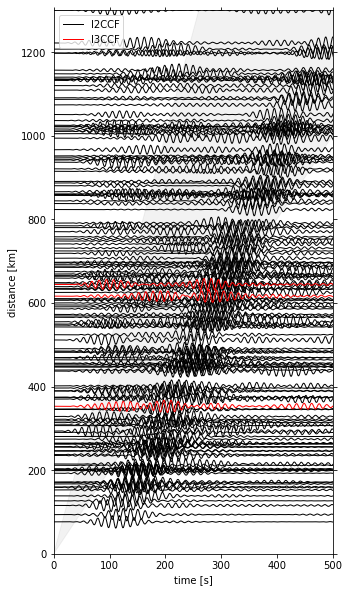

In [9]:
for per in [13]:
    plot_ccf("YH.")
    # name = f'/mnt/home/jieyaqi/Documents/plot/componentcross-correlation functions [{str(rangelist[num])},{str(rangelist[num+1])}]'
    plt.savefig("YH1312-14.pdf",ppi=300)